[![Dataflowr](https://raw.githubusercontent.com/dataflowr/website/master/_assets/dataflowr_logo.png)](https://dataflowr.github.io/website/)

# [Module 6](https://dataflowr.github.io/website/modules/6-convolutional-neural-network/): Convolutions by examples

We'll build our first Convolutional Neural Network (CNN) from scratch.

## 1. Preparations

In [6]:
%matplotlib inline
import math,sys,os,numpy as np
from numpy.linalg import norm
from matplotlib import pyplot as plt

In [7]:
import torch
import torchvision
from torchvision import models,transforms,datasets

Download MNIST data on disk and convert it to pytorch compatible formating.

```torchvision.datasets``` features support (download, formatting) for a collection of popular datasets. The list of available datasets in ```torchvision``` can be found [here](http://pytorch.org/docs/master/torchvision/datasets.html).

Note that the download is performed only once. The function will always check first if the data is already on disk.


In [12]:
root_dir = '/Users/ilpreterosso/GitHub/datasets/NN101-dateflower/MNIST/'
torchvision.datasets.MNIST(root=root_dir,download=True)

Dataset MNIST
    Number of datapoints: 60000
    Root location: /Users/ilpreterosso/GitHub/datasets/NN101-dateflower/MNIST/
    Split: Train

MNIST datasets consists of small images of hand-written digits. The images are grayscale and have size 28 x 28. There are 60,000 training images and 10,000 testing images.

In [13]:
train_set = torchvision.datasets.MNIST(root=root_dir, train=True, download=True)

Define and initialize a data loader for the MNIST data already downloaded on disk.

In [14]:
MNIST_dataset = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True, num_workers=1)

For the current notebook, we can format data as _numpy ndarrays_ which are easier to plot in matplotlib. The same operations can be easily performed on _pytorch Tensors_.

In [15]:
images = train_set.data.numpy().astype(np.float32)/255
labels = train_set.targets.numpy()

In [16]:
print(images.shape,labels.shape)

(60000, 28, 28) (60000,)


## 2. Data visualization

For convenience we define a few functions for formatting and plotting our image data

In [11]:
# plot multiple images

def plots(ims, interp=False, titles=None):
    ims=np.array(ims)
    mn,mx=ims.min(),ims.max()
    f = plt.figure(figsize=(12,24))
    for i in range(len(ims)):
        sp=f.add_subplot(1, len(ims), i+1)
        if not titles is None: sp.set_title(titles[i], fontsize=18, c='#FFFFFF')
        plt.imshow(ims[i], interpolation=None if interp else 'none', vmin=mn,vmax=mx)
        
        _ = plt.gca().axis('off')
    f.set_facecolor('#000000')


# plot a single image
def plot(im, interp=False):
    f = plt.figure(figsize=(3,6), frameon=True)
    plt.imshow(im, interpolation=None if interp else 'none')
    _ = plt.gca().axis('off')
    f.set_facecolor('#000000')

plt.gray()
plt.close()

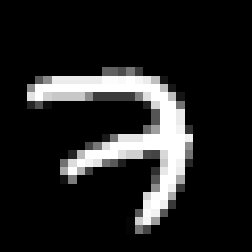

In [12]:
plot(images[5000])

In [13]:
labels[5000]

7

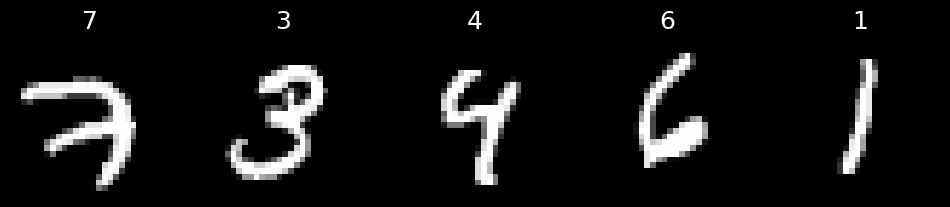

In [14]:
plots(images[5000:5005], titles=labels[5000:5005])

## 3. A simple classifier

In this section we will construct a basic binary classifier.
Our classifier will tell us whether a given image depicts a _one_ or an _eight_. 

We fetch all images from the _eight_ class and from the _one_ class.

In [15]:
n=len(images)

In [16]:
eights=[images[i] for i in range(n) if labels[i]==8]
ones=[images[i] for i in range(n) if labels[i]==1]

In [17]:
len(eights), len(ones)

(5851, 6742)

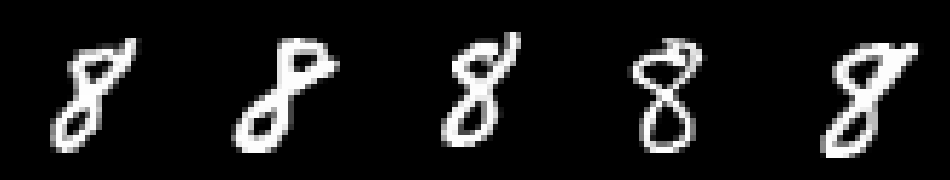

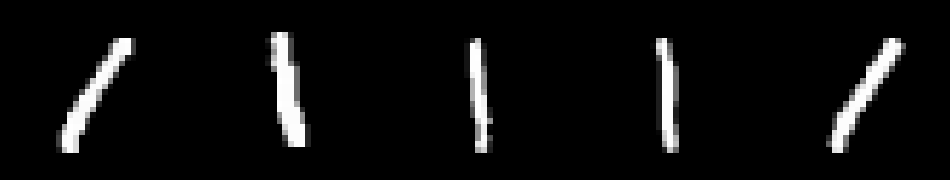

In [18]:
plots(eights[:5])
plots(ones[:5])

We keep the first 1000 digits for the test set and we average all the remaining digits.

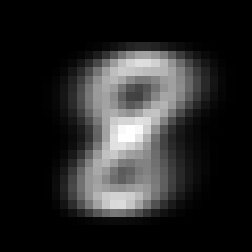

In [19]:
raws8 = np.mean(eights[1000:],axis=0)

plot(raws8)

We now do the same thing with the ones:

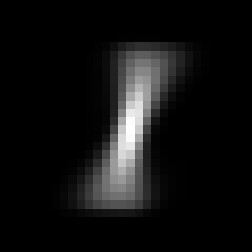

In [20]:
raws1 = np.mean(ones[1000:],axis=0)

plot(raws1)

We built a 'typical representative' of the eights and a 'typical representative' of the ones. Now for a new sample from the test set, we compute the distance between this sample and our two representatives and classify the sample with the label of the closest representative.

For the distance between images, we just take the pixelwise squared distance.

In [21]:
# sum of squared distance
def sse(a,b): return ((a-b)**2).sum()

# return 1 if closest to 8 and 0 otherwise
def is8_raw_n2(im): return 1 if sse(im,raws1) > sse(im,raws8) else 0

In [22]:
nb_8_predicted_8, nb_1_predicted_8 = [np.array([is8_raw_n2(im) for im in ims]).sum() for ims in [eights[:1000],ones[:1000]]]

nb_8_predicted_1, nb_1_predicted_1 = [np.array([(1-is8_raw_n2(im)) for im in ims]).sum() for ims in [eights[:1000],ones[:1000]]]

# just to check 
print(nb_8_predicted_1+nb_8_predicted_8, nb_1_predicted_1+nb_1_predicted_8)

1000 1000


<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/1024px-Precisionrecall.svg.png" alt="Drawing" style="width: 500px;"/>

source [wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall)

In [23]:
def compute_scores(nb_8_predicted_8,nb_8_predicted_1,nb_1_predicted_1,nb_1_predicted_8):
    Precision_8 = nb_8_predicted_8/(nb_8_predicted_8+nb_1_predicted_8)
    Recall_8 = nb_8_predicted_8/(nb_8_predicted_1+nb_8_predicted_8)
    Precision_1 = nb_1_predicted_1/(nb_1_predicted_1+nb_8_predicted_1)
    Recall_1 = nb_1_predicted_1/(nb_1_predicted_1+nb_1_predicted_8)
    return Precision_8, Recall_8, Precision_1, Recall_1

Precision_8, Recall_8, Precision_1, Recall_1 = compute_scores(nb_8_predicted_8,nb_8_predicted_1,nb_1_predicted_1,nb_1_predicted_8)

print('precision 8:', Precision_8, 'recall 8:', Recall_8)
print('precision 1:', Precision_1, 'recall 1:', Recall_1)
print('accuracy :', (Recall_1+Recall_8)/2)

precision 8: 0.9712460063897763 recall 8: 0.912
precision 1: 0.9170593779453345 recall 1: 0.973
accuracy : 0.9425


This is our baseline for our binary classification task. Now your task will be to do better with convolutions!

## 4. Filters and convolutions

Let start with this visual explanation of [Interactive image kernels](http://setosa.io/ev/image-kernels/)

In some fields, convolution or filtering can be better understood as _correlations_. 
In practice we slide the filter matrix over the image (a bigger matrix) always selecting patches from the image with the same size as the filter. We compute the dot product between the filter and the image patch and store the scalar response which reflects the degree of similarity/correlation between the filter and image patch.

Here is a simple 3x3 filter, ie a 3x3 matrix (see [Sobel operator](https://en.wikipedia.org/wiki/Sobel_operator) for more examples)

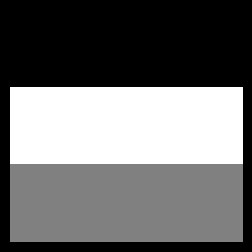

In [24]:
top=[[-1,-1,-1],
     [ 1, 1, 1],
     [ 0, 0, 0]]

plot(top)

We now create a toy image, to understand how convolutions operate.

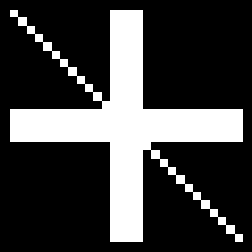

In [25]:
cross = np.zeros((28,28))
cross += np.eye(28)
for i in range(4):
    cross[12+i,:] = np.ones(28)
    cross[:,12+i] = np.ones(28)

plot(cross)

Our `top` filter should highlight top horizontal border in the image.

/var/folders/vv/mm_j1lh17m79th1f4htvv0480000gn/T/ipykernel_7911/3962604546.py:1: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve, correlate
/var/folders/vv/mm_j1lh17m79th1f4htvv0480000gn/T/ipykernel_7911/3962604546.py:1: DeprecationWarning: Please use `correlate` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve, correlate


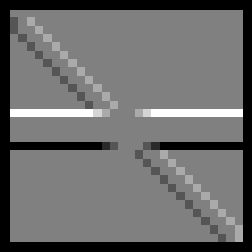

In [26]:
from scipy.ndimage.filters import convolve, correlate
# https://towardsdatascience.com/convolution-vs-correlation-af868b6b4fb5

corr_cross = correlate(cross,top)

plot(corr_cross)

In [8]:
correlate?

Object `correlate` not found.


What is done on the border of the image? 

## Padding

![padding](https://dataflowr.github.io/notebooks/Module6/img/padding_conv.gif)

source: [Convolution animations](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md)

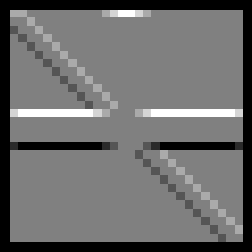

In [28]:
# to see the role of padding
corr_cross = correlate(cross,top, mode='constant')
plot(corr_cross)

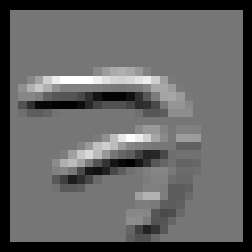

In [29]:
corrtop = correlate(images[5000], top)
plot(corrtop)

By rotating the filter with 90 degrees and calling the ```convolve``` function we get the same response as with the previously called ```correlate``` function.

In [30]:
np.rot90(top, 1)

array([[-1,  1,  0],
       [-1,  1,  0],
       [-1,  1,  0]])

True

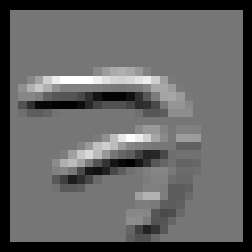

In [31]:
convtop = convolve(images[5000], np.rot90(top,2))
plot(convtop)
np.allclose(convtop, corrtop)

Let's generate a few more variants of our simple 3x3 filter

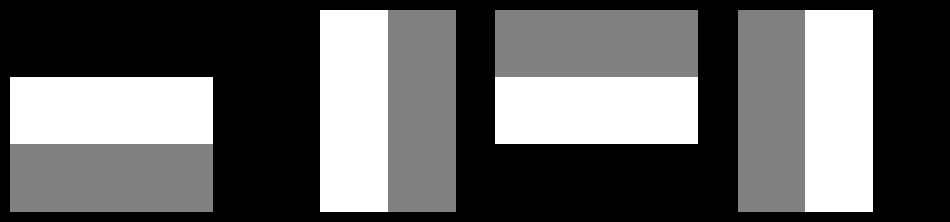

In [32]:
straights=[np.rot90(top,i) for i in range(4)]
plots(straights)

We proceed similarly to generate a set of filters with a different behavior

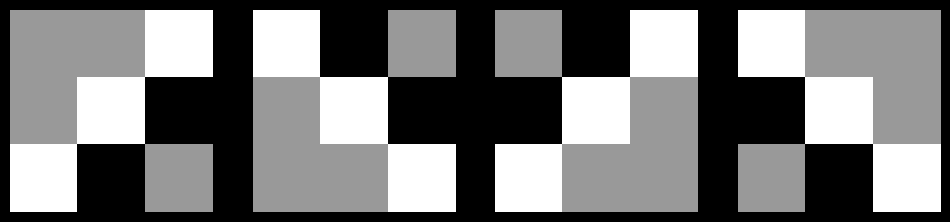

In [33]:
br=[[ 0, 0, 1],
    [ 0, 1,-1.5],
    [ 1,-1.5, 0]]

diags = [np.rot90(br,i) for i in range(4)]
plots(diags)

We can compose filters to obtain more complex patterns

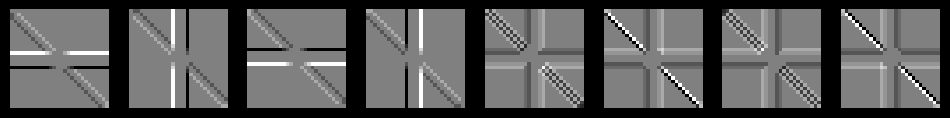

In [34]:
rots = straights + diags
corrs_cross = [correlate(cross, rot) for rot in rots]
plots(corrs_cross)

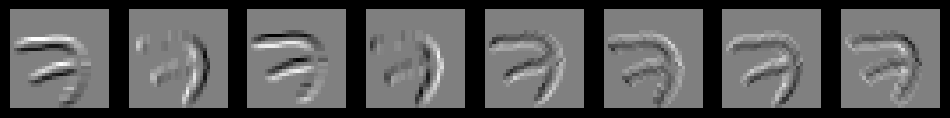

In [35]:
rots = straights + diags
corrs = [correlate(images[5000], rot) for rot in rots]
plots(corrs)

In [60]:
display(images[0].shape, corrs[0].shape) # correlate doesn't change shape

(28, 28)

(28, 28)

Next we illustrate the effect of downsampling.
We select the most basic downsampling technique: __max pooling__. We keep only the maximum value for sliding windows of size ```7x7```.
__Max pooling__ is a handy technique with a few useful perks:
- since it selects the maximum values it ensures invariance to translations
- reducing the size is helpful since data becomes more compact and easier to compare
- we will see later in this course that since max pooling reduces the size of our images, the operations performed later on in the network have bigger receptive field / concern a bigger patch in the input image and allow the discovery of higher level patterns.

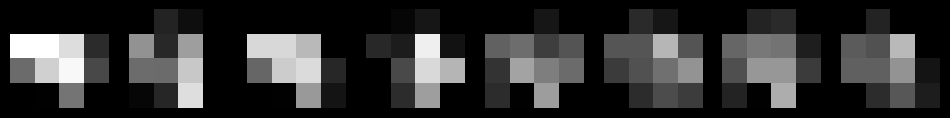

In [36]:
import skimage

from skimage.measure import block_reduce

def pool(im): 
    # scan the img by 7*7 sliding 'pool' and extract the max value
    return block_reduce(im, (7,7), np.max)

plots([pool(im) for im in corrs])

We now build a classifier with convolutions.

To this end we select a set of training images depicting _eights_ and _ones_, we convolve them with our set of filters, pool them and average them for each class and filter. We will thus obtain a set of _representative_ signatures for _eights_ and for _ones_. 
Given a new test image we compute its features by convolution and pooling with the same filters and then compare them with the _representative_ features. The class with the most _similar_ features is chosen as prediction.


We keep 1000 images of _eight_ for the test set and use the remaining ones for the training: we convolve them with our bank of filters, perform max pooling on the responses and store them in ```pool8```.

In [37]:
# for each rotated paddings in rots
# 1) applying the padding to imgs through correlation (conv)
# 2) extract max value in each pool (max_pool)
pool8 = [np.array([pool(correlate(im, rot)) for im in eights[1000:]]) for rot in rots]

In [38]:
len(pool8), pool8[0].shape

(8, (4851, 4, 4))

We plot the result of the first filter+pooling on the first 5 _eights_ in our set. 

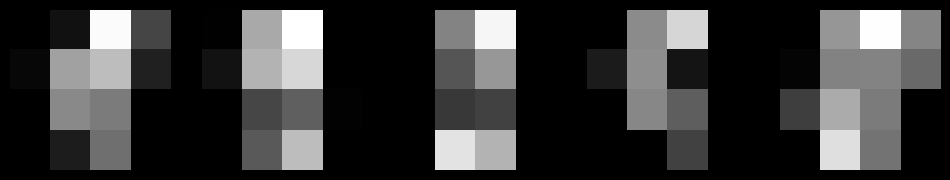

In [39]:
plots(pool8[0][0:5])

For the 4 first _eights_ in our set, we plot the result of the 8 filters+pooling

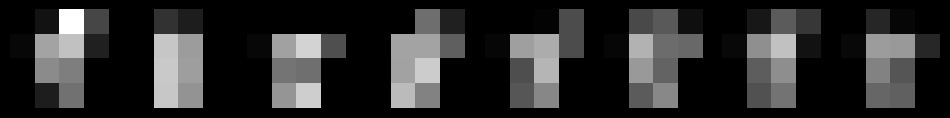

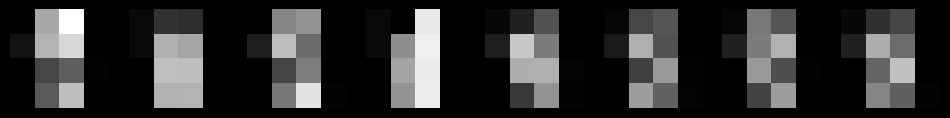

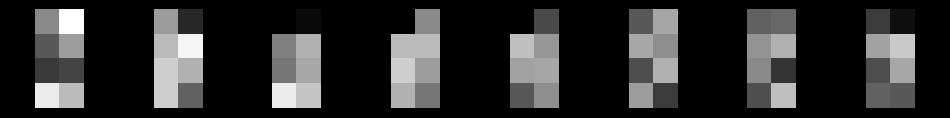

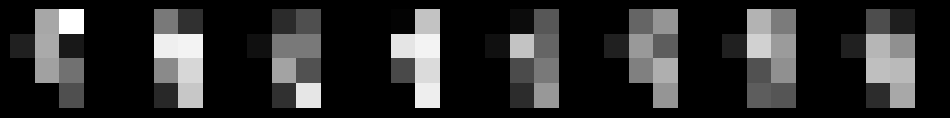

In [40]:
plots([pool8[i][0] for i in range(8)])
plots([pool8[i][1] for i in range(8)])
plots([pool8[i][2] for i in range(8)])
plots([pool8[i][3] for i in range(8)])

We normalize the data in order to smoothen activations and bring them to similar ranges of values

In [41]:
def normalize(arr): return (arr-arr.mean())/arr.std()

Next we compute the average _eight_ by averaging all responses for each filter from _rots_.

In [42]:
filts8 = np.array([ims.mean(axis=0) for ims in pool8])
filts8 = normalize(filts8)

We should obtain a set of canonical _eights_ responses for each filter.

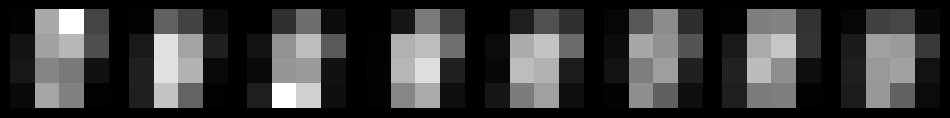

In [43]:
plots(filts8)

We proceed similarly with training samples from the _one_ class and plot the canonical _ones_.

In [44]:
pool1 = [np.array([pool(correlate(im, rot)) for im in ones[1000:]]) for rot in rots]
filts1 = np.array([ims.mean(axis=0) for ims in pool1])
filts1 = normalize(filts1)

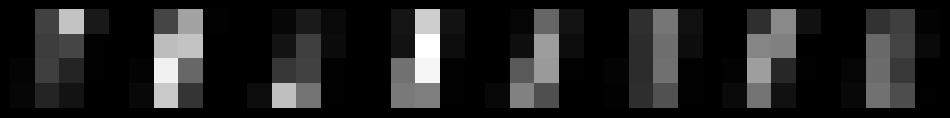

In [45]:
plots(filts1)

Do you notice any differences between ```filts8``` and ```filts1```? Which ones?

We define a function that correlates a given image with all filters from ```rots``` and max pools the responses.

In [46]:
def pool_corr(im): return np.array([pool(correlate(im, rot)) for rot in rots])

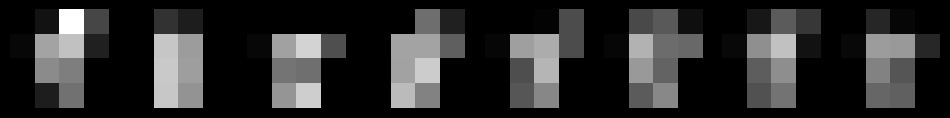

In [47]:
plots(pool_corr(eights[1000]))

True

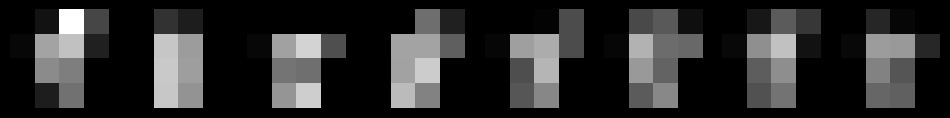

In [48]:
#check 
plots([pool8[i][0] for i in range(8)])
np.allclose(pool_corr(eights[1000]),[pool8[i][0] for i in range(8)])

In [49]:
# function used for a voting based classifier that will indicate which one of the 
# two classes is most likely given the sse distances
# n2 comes from norm2
# is8_n2 returns 1 if it thinks it's an eight and 0 otherwise
def is8_n2(im): return 1 if sse(pool_corr(im),filts1) > sse(pool_corr(im),filts8) else 0

We perform a check to see if our function actually works. We correlate the an image of _eight_ with ```filts8``` and ```filts1```. It should give smaller distance for the _eights_.

In [50]:
sse(pool_corr(eights[0]), filts8), sse(pool_corr(eights[0]), filts1)

(103.67323, 126.09805)

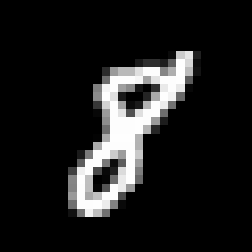

In [51]:
plot(eights[0])

In [56]:
eights[0].shape

(28, 28)

We now test our classifier on the 1000 images of _eights_ and 1000 images of _ones_

In [52]:
nb_8_predicted_8, nb_1_predicted_8 = [np.array([is8_n2(im) for im in ims]).sum() for ims in [eights[:1000],ones[:1000]]]

nb_8_predicted_1, nb_1_predicted_1 = [np.array([(1-is8_n2(im)) for im in ims]).sum() for ims in [eights[:1000],ones[:1000]]]

In [53]:
Precisionf_8, Recallf_8, Precisionf_1, Recallf_1 = compute_scores(nb_8_predicted_8,nb_8_predicted_1,nb_1_predicted_1,nb_1_predicted_8)

print('precision 8:', Precisionf_8, 'recall 8:', Recallf_8)
print('precision 1:', Precisionf_1, 'recall 1:', Recallf_1)
print('accuracy :', (Recallf_1+Recallf_8)/2)
print('accuracy baseline:', (Recall_1+Recall_8)/2)

precision 8: 0.963220675944334 recall 8: 0.969
precision 1: 0.9688128772635815 recall 1: 0.963
accuracy : 0.966
accuracy baseline: 0.9425


We improved the accuracy while reducing the embedding size from a $28\times 28 = 784$ vector to a $4\times 4\times 8 = 128$ vector.

We have successfully built a classifier for _eights_ and _ones_ using features extracted with a bank of pre-defined features and a set of training samples. 

## 5. Practicals: improving classification with Convolutional Neural Net

You will now build a neural net that will learn the weights of the filters.

The first layer of your network will be a convolutional layer with $8$ filters of size $3\times 3$. Then you will apply a Max Pooling layer to reduce the size of the image to $4\times 4$ as we did above. This will produce a (once flatten) a vector of size $128 = 4\times 4\times 8$. From this vector, you need to predict if the corresponding input is a $1$ or a $8$. So you are back to a classification problem as seen in previous lesson.

You need to fill the code written below to construct your CNN. You will need to look for documentation about [torch.nn](https://pytorch.org/docs/stable/nn.html) in the Pytorch doc.

In [1]:
import torch.nn as nn
import torch.nn.functional as F

In [8]:
class classifier(nn.Module):
    
    def __init__(self):
        super(classifier, self).__init__()
        # fill the missing entries below
        # in_channels = 1, meaning grey-scaled images
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1, padding_mode='zeros', stride=1)
        
        # Where did the 128 come from?
        # recall the image dimension is 28 * 28, kernel_size=3 with padding=1 outputs 28 * 28 tensors
        # max_pool2d of 7 * 7  kernel gives 4 * 4 output tensoer (28 / 7 = 4)
        # **note that** every sample block in maxpool are disjoint (not like in correlate)
        # now that we have 128 = (img shape).flatten * out channel num = 4 * 4 * 8
        self.fc = nn.Linear(in_features=128, out_features=2)
        
    def forward(self,x: torch.Tensor):
        # implement your network here, use F.max_pool2d, F.log_softmax and do not forget to flatten your vector
        x = self.conv1(x)
        
        # Your code here
        x = F.max_pool2d(x, 7)
        # flatten only the imgs, not the whole batch
        x = x.flatten(start_dim=1)
        x = self.fc(x)
        x = F.log_softmax(x, dim=1)
        return x

In [4]:
class a():
    def __init__(self) -> None:
        self.I_love = 'shit'
        pass

class b(a):
    def __init__(self) -> None:
        super(b, self).__init__()
        # quiv. to super().__init__()
        display(self.I_love)
    
b()

'shit'

In [10]:
conv_class = classifier()

Your code should work fine on a batch of 3 images.

In [148]:
batch_3images = train_set.data[0:2].type(torch.FloatTensor).resize_(3, 1, 28, 28)
#conv_class(batch_3images)

In [171]:
test_img = eights[0]
test_img = test_img.reshape(1, test_img.shape[0], test_img.shape[1])
test_img = torch.tensor(test_img)
t = conv_class.conv1(test_img)
display(t.shape)
t = F.max_pool2d(t, 7)
display(t.shape)
t = conv_class.fc(t.flatten())
F.log_softmax(t, dim=0) # use dim=1 for patches

torch.Size([8, 28, 28])

torch.Size([8, 4, 4])

tensor([-5.2208e-03, -5.2577e+00], grad_fn=<LogSoftmaxBackward0>)

The following lines of code implement a data loader for the train set and the test set. No modification is needed.

In [155]:
bs = 64

l8 = np.array(0)
eights_dataset = [[torch.from_numpy(e.astype(np.float32)).unsqueeze(0), torch.from_numpy(l8.astype(np.int64))] for e in eights]
l1 = np.array(1)
ones_dataset = [[torch.from_numpy(e.astype(np.float32)).unsqueeze(0), torch.from_numpy(l1.astype(np.int64))] for e in ones]
train_dataset = eights_dataset[1000:] + ones_dataset[1000:]
test_dataset = eights_dataset[:1000] + ones_dataset[:1000]

train_loader = torch.utils.data.DataLoader(train_dataset,
    batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,
    batch_size=bs, shuffle=True)

You need now to code the training loop. Store the loss and accuracy for each epoch.

In [183]:
display(torch.max(torch.tensor([0, .5]), dim=0))
display(torch.max(torch.tensor([[0, .5], [0, .4]]), dim=1))
t = torch.max(torch.tensor([[0, .5], [0, .4]]), dim=1)
display(t.indices)
_, preds = t
display(preds)

torch.return_types.max(
values=tensor(0.5000),
indices=tensor(1))

torch.return_types.max(
values=tensor([0.5000, 0.4000]),
indices=tensor([1, 1]))

tensor([1, 1])

tensor([1, 1])

In [184]:
def train(model,data_loader,loss_fn,optimizer,n_epochs=1):
    model.train(True)
    loss_train = np.zeros(n_epochs)
    acc_train = np.zeros(n_epochs)
    for epoch_num in range(n_epochs):
        running_corrects = 0.0
        running_loss = 0.0
        size = 0

        for data in data_loader:
            inputs, labels = data
            bs = labels.size(0)
            #
            #
            # Your code here
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            # get gradient
            optimizer.zero_grad()
            loss.backward()
            # apply gradient descent
            optimizer.step()
            # get accuracy in each epoch
            preds = torch.max(outputs, 1).indices
            #_,preds = torch.max(outputs,dim=1)
            running_corrects += torch.sum(preds == labels)
            # accumilate loss in one batch
            running_loss += loss.data
            
            size += bs
        epoch_loss = running_loss.item() / size
        epoch_acc = running_corrects.item() / size
        loss_train[epoch_num] = epoch_loss
        acc_train[epoch_num] = epoch_acc
        print('Train - Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    return loss_train, acc_train

In [188]:
conv_class = classifier()
# choose the appropriate loss
loss_fn = nn.NLLLoss()
# your SGD optimizer
learning_rate = 1e-3
optimizer_cl = torch.optim.SGD(conv_class.parameters(), learning_rate)
# and train for 10 epochs
l_t, a_t = train(conv_class,train_loader,loss_fn,optimizer_cl,n_epochs = 10)

Train - Loss: 0.0110 Acc: 0.4200
Train - Loss: 0.0107 Acc: 0.6665
Train - Loss: 0.0104 Acc: 0.8724
Train - Loss: 0.0102 Acc: 0.9313
Train - Loss: 0.0099 Acc: 0.9421
Train - Loss: 0.0096 Acc: 0.9599
Train - Loss: 0.0094 Acc: 0.9606
Train - Loss: 0.0091 Acc: 0.9616
Train - Loss: 0.0088 Acc: 0.9670
Train - Loss: 0.0085 Acc: 0.9649


Let's learn for 10 more epochs

In [179]:
l_t1, a_t1 = train(conv_class,train_loader,loss_fn,optimizer_cl,n_epochs = 10)

Train - Loss: 0.0003 Acc: 0.9947
Train - Loss: 0.0003 Acc: 0.9944
Train - Loss: 0.0003 Acc: 0.9954
Train - Loss: 0.0002 Acc: 0.9946
Train - Loss: 0.0002 Acc: 0.9948
Train - Loss: 0.0002 Acc: 0.9956
Train - Loss: 0.0002 Acc: 0.9955
Train - Loss: 0.0002 Acc: 0.9959
Train - Loss: 0.0002 Acc: 0.9961
Train - Loss: 0.0002 Acc: 0.9962


Our network seems to learn but we now need to check its accuracy on the test set.

In [186]:
def test(model,data_loader):
    model.train(False)

    running_corrects = 0.0
    running_loss = 0.0
    size = 0

    for data in data_loader:
        inputs, labels = data
            
        bs = labels.size(0)
        #
        # Your code here
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        preds = torch.max(outputs, dim=1).indices
        running_corrects += torch.sum(preds==labels)
        running_loss += loss.data
        
        size += bs

    print('Test - Loss: {:.4f} Acc: {:.4f}'.format(running_loss / size, running_corrects.item() / size))

In [187]:
test(conv_class,test_loader)

Test - Loss: 0.0004 Acc: 0.9945


Change the optimizer to Adam.

In [189]:
conv_class = classifier()
# choose the appropriate loss
loss_fn = nn.NLLLoss()
# your SGD optimizer
learning_rate = 1e-3
optimizer_cl = torch.optim.Adam(conv_class.parameters(), learning_rate)
# and train for 10 epochs
l_t, a_t = train(conv_class,train_loader,loss_fn,optimizer_cl,n_epochs = 10)

Train - Loss: 0.0065 Acc: 0.8667
Train - Loss: 0.0025 Acc: 0.9618
Train - Loss: 0.0014 Acc: 0.9794
Train - Loss: 0.0010 Acc: 0.9847
Train - Loss: 0.0007 Acc: 0.9876
Train - Loss: 0.0006 Acc: 0.9891
Train - Loss: 0.0005 Acc: 0.9900
Train - Loss: 0.0005 Acc: 0.9909
Train - Loss: 0.0004 Acc: 0.9920
Train - Loss: 0.0004 Acc: 0.9924


How many parameters did your network learn?

You can see them as follows:

In [193]:
for m in conv_class.children():
    print('weights :', m.weight.data)
    print('bias :', m.bias.data)

weights : tensor([[[[ 0.3575,  0.1549, -0.6151],
          [ 0.5464,  0.0424,  0.0044],
          [ 0.1465,  0.2482,  0.2477]]],


        [[[-0.4761, -0.9049,  0.0413],
          [ 0.0911,  0.0874,  0.5501],
          [ 0.7214,  0.3181,  0.0405]]],


        [[[ 0.1694,  0.3800,  0.8076],
          [ 0.3238, -0.3095,  0.4543],
          [-0.6347, -0.8507,  0.0293]]],


        [[[ 0.4849,  0.5897, -0.3421],
          [ 0.4627,  0.2971, -0.5853],
          [ 0.5140,  0.4612, -0.1063]]],


        [[[-0.2247, -0.0430,  0.1343],
          [-0.1199,  0.2828,  0.2005],
          [-0.5534,  0.1125, -0.0309]]],


        [[[-0.7951, -0.3775,  0.3745],
          [ 0.3197,  0.4997,  0.1102],
          [ 0.2146,  0.2574, -0.5334]]],


        [[[-0.1354,  0.1382,  0.4782],
          [ 0.5686,  0.5691,  0.3177],
          [ 0.2226,  0.3135,  0.4253]]],


        [[[-0.1647,  0.3799,  0.3704],
          [ 0.5683,  0.5324,  0.3974],
          [ 0.1519,  0.2657,  0.3107]]]])
bias : tensor([-0.4454,

In [203]:
for m in conv_class.children():
    T_w = m.weight.data.numpy()
    T_b = m.bias.data.numpy()
    break

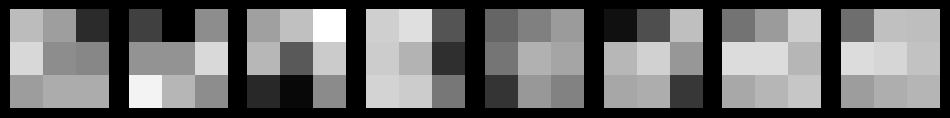

In [204]:
plots([T_w[i][0] for i in range(8)])

In [ ]:
T_b

[![Dataflowr](https://raw.githubusercontent.com/dataflowr/website/master/_assets/dataflowr_logo.png)](https://dataflowr.github.io/website/)